In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import save_model, model_from_json, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras.models import load_model
from keras_tuner.engine.hyperparameters import HyperParameters
from typing import Union
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
df = pd.read_csv('../data/cleaned_data_daily.csv')
data = df['close'].values
data = data.reshape(-1,1)

In [3]:
def min_max_scale(train: np.array, val:np.array, test: np.array) -> Union[MinMaxScaler, np.array, np.array, np.array]:
    """ Tranform the train and test data into min max scale of train data"""
    scaler = MinMaxScaler()
    scaler = scaler.fit(train)
    train_normalized = scaler.transform(train)
    test_normalized = scaler.transform(test)
    val_normalized = scaler.transform(val)
    return scaler, train_normalized, val_normalized, test_normalized

def data_divider(data: np.array, threshold: int):
    """ This functions divideds the data (close price) into 80 20 ration for test and train data """
    train_test_divider = int(len(data)*threshold)
    training_data, testing_data = data[:train_test_divider], data[train_test_divider:]
    return training_data, testing_data

def sliding_window(data: [], window_length: int) -> Union[np.array, np.array]:
    """ 
    This function creates a sliding window pattern from the data given and window length given.
    For example:
    Data = [[1],[2],[3],[4],[5],[6]]
    sliding window = 2
    X = [[[1],[2]],[[2],[3]],[[3],[4]],[[4],[5]]]
    Y = [[3],[4],[5],[6]]
    
    """
    X = []
    Y = []
    for i in range(len(data) - window_length):
        X.append(data[i: i+ window_length])
        Y.append(data[i+window_length])
    
    return np.array(X), np.array(Y)

def model_builder(hp):
    """ Keras hyper paramter tuner model builder"""

    np.random.seed(1234)
    tf.random.set_seed(1234) 
    hp_activation = hp.Choice('activationfunc', ['relu', 'tanh', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.05, 0.1, 0.2])  
    model = Sequential()
    model.add(LSTM(hp.Int('first_layer_neurons', min_value=1, max_value=25, step=1), 
                   activation= hp_activation, return_sequences=True))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(hp.Int('second_layer_neurons', min_value=1, max_value=25, step=1), activation= hp_activation))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=hp.Choice('optimizer',['RMSProp', 'Adam', 'SGD', 'ADAMAX'] ),
                  loss='mse',
                  metrics='mse')
    return model

def show_best_hyperparamters(best_hps):
    print('Best Hyper Parameters\n')
    print('Layer 1 neuron: ', best_hps.get('first_layer_neurons'))
    print('Layer 2 neuron: ' , best_hps.get('second_layer_neurons'))
    print('Activation Function: ', best_hps.get('activationfunc'))
    print('learning_rate: ', best_hps.get('learning_rate'))
    print('Dropout rate: ', best_hps.get('dropout'))
    print('Optimizer: ', best_hps.get('optimizer'))
    
def calculate_metrics(test: np.ndarray, predict: np.ndarray) -> float:
    """."""
#     print(f'RMSE: {mean_squared_error(test.flatten(), predict.flatten(), squared=False)}')
    print(f'MSE: {mean_squared_error(test.flatten(), predict.flatten())}')
    print(f'MAE: {mean_absolute_error(test.flatten(), predict.flatten())}')

In [4]:
lookback = 2
train, test = data_divider(data, 0.8)
# val, test = data_divider(test, 0.5)
scaler, train_normalized, val_normalized, test_normalized = min_max_scale(train, test, test)
x_train, y_train = sliding_window(train_normalized, lookback)
x_val, y_val = sliding_window(val_normalized, lookback)
x_test, y_test = sliding_window(test_normalized, lookback)

In [5]:
tuner = kt.RandomSearch(model_builder, objective='val_mse', max_trials=30, directory='my_dir', project_name='keras-daily-lstm')
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

INFO:tensorflow:Reloading Oracle from existing project my_dir\keras-daily-lstm\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\keras-daily-lstm\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [6]:
best_hps = tuner.get_best_hyperparameters()[0]
show_best_hyperparamters(best_hps)

Best Hyper Parameters

Layer 1 neuron:  7
Layer 2 neuron:  6
Activation Function:  tanh
learning_rate:  0.001
Dropout rate:  0.2
Optimizer:  Adam


In [8]:
# Build the model with the best hp.
model = model_builder(best_hps)
### train it ###
stop_training_early = keras.callbacks.EarlyStopping(monitor="loss", patience = 1)
history = model.fit(x_train, y_train, epochs=350 , verbose=1, shuffle=False, callbacks=[stop_training_early])

Epoch 1/350
43/43 [==============================] - 4s 4ms/step - loss: 0.0596 - mse: 0.0596    
Epoch 2/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0496 - mse: 0.0496
Epoch 3/350
43/43 [==============================] - 0s 4ms/step - loss: 0.0463 - mse: 0.0463
Epoch 4/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0444 - mse: 0.0444
Epoch 5/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0418 - mse: 0.0418
Epoch 6/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0388 - mse: 0.0388
Epoch 7/350
43/43 [==============================] - 0s 4ms/step - loss: 0.0361 - mse: 0.0361
Epoch 8/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0314 - mse: 0.0314
Epoch 9/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0265 - mse: 0.0265
Epoch 10/350
43/43 [==============================] - 0s 3ms/step - loss: 0.0212 - mse: 0.0212
Epoch 11/350
43/43 [==============================] - 0

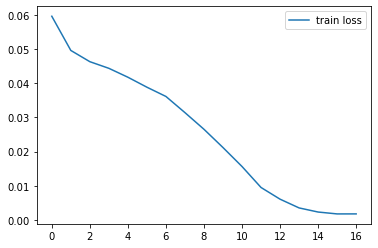

In [9]:
plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [11]:
# model = load_model('saved_model/LSTM_daily')
# model.save('saved_model/LSTM_daily')
# model.summary()

## Prediction

In [13]:
y_predict = model.predict(x_val)

11/11 [==============================] - 1s 2ms/step


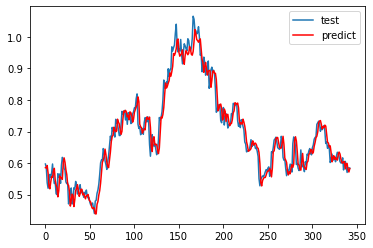

In [14]:
plt.plot(y_val.flatten(), label='test')
plt.plot(y_predict.flatten(), 'r-', label='predict')
plt.legend()

In [15]:
calculate_metrics(y_test, y_predict)

MSE: 0.0011017206563439215
MAE: 0.025494885752965664


## WALK OVER PREDICTION


In [ ]:
# predictions = []
# predictions_inversed = []
# history = train_normalized
# for i in tqdm(test_normalized):
#     history = history[-lookback:] 
#     ## new axis because 3D is expected as input ##
#     prediction = model.predict(history[np.newaxis,:,:], verbose = 0)
#     predictions_inversed.append(float(scaler.inverse_transform(prediction)))
#     predictions.append(float(prediction))
#     ## a square bracket to match dimension at individual level ##
#     history = np.append(history, [i], axis=0)

In [ ]:
# print(f'RMSE: {mean_squared_error(predictions, test_normalized.flatten(), squared=False)}')
# print(f'RMSE: {mean_squared_error(predictions_inversed, test, squared=False)}')

In [ ]:
# plt.plot(test, label='test')
# plt.plot(predictions_inversed, 'r-', label='predict')
# # plt.legend()